# Generate Myocardal Tensor-maps from random eigen-value samples

This Notebook provides a demonstration of how to creating random tensormaps using a left-ventricle myocard mask.     
Creating the maps follows the following steps:
1. Rejection-sample random eigen-value triplets 
2. Create ideal tensors inside the mask (according to Helix and Sheetlet angles)
3. Select random points inside the mask and scale the Tensors such that the first EV is the largest
4. Interpolate the reference tensors with RBF-kernel at every mask point

## Sections
2. Import packages
3. Generate eigen-value samples
4. Generate map
5. Evalutate maps in plots
     

# Import packages
---

In [ ]:
import tensorflow as tf
cuda_visible_devices = tf.config.list_physical_devices(device_type='GPU')
tf.config.set_visible_devices([], device_type='GPU')

In [ ]:
import os
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from tqdm.notebook import tqdm
import seaborn as sns

from skimage.transform import resize

import project_lib.data_generation.myocard_tensormaps as myo_module
from project_lib.data_generation import interpolation
import cdtipy

import ipywidgets as widgets
%matplotlib widget

# Generate eigen-value samples
---

The rejection sampling process first requires a "burn-in" phase, in which non-rejected sampling is used to generate an approximation of the eigenvalue distributions within the specified MD and FA ranges. A smoothed version of the FA - distribution is stored in a npz file which can be used to load the weights when instantiating the monte-carlo-sampler. It is used to construct the MC-decision threshold according to the rejection sampling condition:
```math
Let Y be a Random variable with density g(y)
Let f(Y) be the target distribution, \mathcal{U}(a, b)
Let U be a Random variable with density \mathcal{U}(0, cg(y))
if  U < f(Y) accept the sample.
```

The non-rejected sampling process is as follows:     
 1. Uniformly sample a MD value from specified range
 2. Sample 3 eigenvalues from the specified ranges
 3. Project the eigenvalue triple onto the plane defined by the sampled MD value, which results in a non-uniform distribution on the simplex (Fig1).
Fig.2 shows how a subspace of constant FA for a fixed, constant MD is a circle on the simplex plane. So the goal of the rejection sampling process is to have a uniform distribution inside the FA-ring defined by the box-constraints, for all MD planes.     

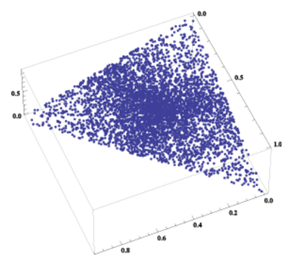
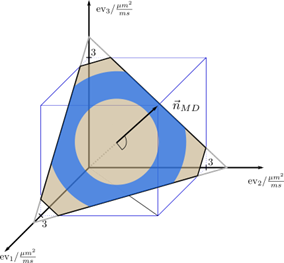
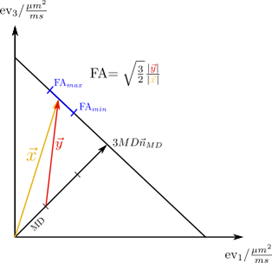    
---

In [ ]:
import project_lib.data_generation.sample_eigenvalues as sampling_module

# Burn in MC-sampler
sampling_intervals = {}
ev_support = np.array([[0, 3], [0, 3], [0, 3]], np.float32)

trace_support = (np.array((-0.38, 0.38), dtype=np.float) + 1.5) * 3
fa_support = np.array([[-0.15, 0.15], ], dtype=np.float32) + 0.34 + 0.06
sampling_intervals.update({f'diffusion_healthy_exp': (ev_support, trace_support.copy(), fa_support.copy(), 1e5)})

trace_support = (np.array((-0.38, 0.38), dtype=np.float) + 1.59) * 3
fa_support = np.array([[-0.15, 0.15], ], dtype=np.float32) + 0.29 + 0.06
sampling_intervals.update({f'diffusion_lesion_exp': (ev_support, trace_support.copy(), fa_support.copy(), 1e5)})

directory = "../results/simulation_resources"
os.makedirs(directory, exist_ok=True)
with tf.device("CPU:0"):
    for suffix, (eigenvalue_supports, tr_sup, fa_support, nburnin) in sampling_intervals.items():
        if not os.path.exists(f'{directory}/sampler_{suffix}.npz'):
            mc_sampler = sampling_module.MCRejectionSampler(tr_sup, eigenvalue_supports, fa_support, 
                                                            sampling_method=sampling_module.exponentially_sample_simplex, burn_in_samples=int(nburnin))
            mc_sampler.save(f'{directory}/sampler_{suffix}.npz')

In [ ]:
samplers = [sampling_module.MCRejectionSampler.from_savepath(f"{directory}/sampler_diffusion_{s}.npz",
                                                             sampling_method=sampling_module.exponentially_sample_simplex) 
            for s in ("healthy_exp", "lesion_exp")]

with tf.device("CPU:0"):
    n = 50000
    healthy_samples = samplers[0].get_samples(n)
    lesion_samples = samplers[1].get_samples(n)

sample_populations = [healthy_samples.numpy(), lesion_samples.numpy()]    

To illustrate the resulting eigenvalue distrubtion the following cell plots the marginal distribution of the Eigen values, MD and FA as well as a joint 2D histogram of the tensor trace and FA 

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

plt.rc('axes', linewidth=2)
plt.rc('font', weight="bold", size=10)
plt.close('all')

tab = widgets.Tab(children=[widgets.Output() for _ in range(3)])
[tab.set_title(i,t) for i, t in enumerate(['Marginal Distributions', 'Joint FA-Tr Distribution', 'MC-descision boundaries'])]
display(tab)

with tab.children[0]:
    f, a = plt.subplots(1, 5, sharey=True)
    for s, c in zip(sample_populations, (None, "orange")):
        [sns.histplot(data=x, kde=True, ax=a[i], bins=30, alpha=0.4, color=c, stat='probability') 
         for  i, x in enumerate([*s.T, np.mean(s, axis=-1), np.array(cdtipy.tensor_metrics.fractional_anisotropy(s))])]
    
    [(a[i].set_title(t), a[i].grid(True), a[i].legend(['healthy', 'lesion'])) for i, t in enumerate(['EV1', 'EV2', 'EV3', 'MD', 'FA'])], 
    
    for ax in a:
        ax.xaxis.get_ticklocs(minor=True)
        ax.minorticks_on()
    
    [_.set_xlabel(r"$10^{-3}mm^2/s$") for _ in a[:-1]]
    f.set_size_inches(12, 5), f.tight_layout()
    plt.show(f)
    
with tab.children[1]:
    def get_surface_arrays(evs):
        fa, trace = np.array(cdtipy.tensor_metrics.fractional_anisotropy(evs)), np.sum(evs, axis=1)
        print(fa.shape)
        fa_bin_edges, md_bin_edges = np.linspace(0., 0.65, 25), np.linspace(0.5, 6.5, 25)
        H, x_edges, y_edges = np.histogram2d(fa, trace, bins=(fa_bin_edges, md_bin_edges))
        X, Y = np.meshgrid( (fa_bin_edges[1:] + fa_bin_edges[0:-1]) / 2, 
                            (md_bin_edges[1:] + md_bin_edges[0:-1]) / 2, indexing='ij')
        return X, Y, H
    f = plt.figure()
    ax = f.add_subplot(111, projection='3d')
    ax.plot_surface(*get_surface_arrays(healthy_samples)), ax.set_xlabel('FA'), ax.set_ylabel('Tr'), f.suptitle('Joint distribution')
    
with tab.children[2]:
    f, ax = plt.subplots(1, 1)
    [ax.plot(np.linspace(*sampler._value_range, sampler._n_bins), sampler.mc_decision_boundaries.flatten(), ".--") for sampler in samplers]
    plt.show(f)

# Generate map
---
The function that generates a single tensor-map is `project_lib.data_generation.myocard_tensormaps.get_interpolated_tensormap`. To inspect the function load the source code by uncommenting the cellmagic %load in the susequent cell. To run the local functions the additional imports in the next cell need to be uncommented as well.

In [ ]:
# These imports are necessary if the source code is loaded
# from cdtipy import utils
# from cdtipy import coordinates as coordinate_transforms
# from typing import Tuple, Union
# ideal_helix_angle_map = myo_module.ideal_helix_angle_map
# create_eigenbasis_map = myo_module.create_eigenbasis_map
# e2a_map = myo_module.e2a_map

In [ ]:
# %load (inspect.getsource(myo_module.get_interpolated_tensormap)

In [ ]:
seed_fraction=0.08
ha_range=140.
interpolation_kernel='rbf'
kernel_kwargs={'kernel_variance':3.e-6, "distance_weights": (1., 0.85)}
e2a_kwargs={'low_res_step': 3, 'seed_fraction': 1/5, 'prob_high': 0.5, 'kernel_variance': 0.01, 
            'distance_weights': (1., 0.75), 'offset': 5., 'high_angle_value': 90.}

__Actual function call__    
Instead of as mask any ring-like binary mask can be used. As an example a MRXCAT mask is loaded. Depending on the available GPU memory and the drivers, the interpolation has to be executed on CPU which should be sufficiently fast for demonstration.

In [ ]:
tissue_map = np.load('../results/simulation_resources/reference/mask.npy')
mask = np.where(tissue_map == 1, np.ones_like(tissue_map), np.zeros_like(tissue_map))
# mask = np.around(resize(mask, (mask.shape[0] // 2, mask.shape[1] // 2)))

fov = np.array([0.304, 0.102], np.float32)
xi, xj, yi, yj = [int(i * k) for i, k in zip([0.35, 0.65, 0.15, 0.85], [mask.shape[0], mask.shape[0], mask.shape[1], mask.shape[1]])] 

with tf.device('CPU:0'):
    tensor_map = myo_module.get_interpolated_tensormap(mask, fov, healthy_samples, seed_fraction=seed_fraction,
                                                       ha_range=ha_range, interpolation_kernel=interpolation_kernel,
                                                       kernel_kwargs=kernel_kwargs, e2a_kwargs=e2a_kwargs) 
    tensor_map = tensor_map * 1e-3

#  Evalutate maps in plots
---
Now use the cdti-package to inspect the produced tensor-map:

In [ ]:
plt.close('all')

fake_data = np.around(resize(tissue_map, (mask.shape[0], mask.shape[1])))[xi:xj, yi:yj, np.newaxis]
nan_mask = mask.copy()[xi:xj, yi:yj]
nan_mask[nan_mask==0] = np.nan
with tf.device("CPU:0"):
    metrics = cdtipy.tensor_metrics.metric_set(tensor_map)
    metrics_c = {k: np.einsum("xy, xy... -> xy...", nan_mask, v[xi:xj, yi:yj]) for k, v in metrics.items()}

    evals, evecs = metrics_c['evals'], metrics_c['evecs']

    angles = cdtipy.angulation.angulation_set(metrics['evecs'], mask, fov)
    angles_c = {k: v[xi:xj, yi:yj] for k, v in angles.items()}

    res_sum = cdtipy.plotting.ipywidget_collections.ResultSummary(metrics_c, angles_c, field_of_view=fov, mask=nan_mask, data=fake_data,
                                                                  tabs_to_plot=(False, False, True, True, False, True))


This plot shows, how the statistics of mean values for MD and FA per map look like:

In [ ]:
nan_mask = mask.copy()
nan_mask[nan_mask==0] = np.nan


md_means, fa_means = [], []
md_means2, fa_means2 = [], []

for acc_m, acc_fa, smpls in zip([md_means, md_means2], [fa_means, fa_means2], [healthy_samples, lesion_samples]):
    for i in tqdm(range(50)):
        with tf.device('CPU:0'):
            tensor_map = myo_module.get_interpolated_tensormap(mask, fov, smpls, seed_fraction=seed_fraction, 
                                                               ha_range=ha_range, interpolation_kernel=interpolation_kernel,
                                                               kernel_kwargs=kernel_kwargs, e2a_kwargs=e2a_kwargs) 
            tensor_map = tensor_map * 1e-3
            metrics = cdtipy.tensor_metrics.metric_set(tensor_map)
            md = np.einsum("xyii", tensor_map) / 3
            acc_m.extend(metrics["MD"][np.where(md > 0)].tolist())
            acc_fa.extend(metrics["FA"][np.where(md > 0)].tolist())
            
            
plt.close("all")
f, (a1, a2) = plt.subplots(1, 2)
a1.set_title(r"$\langle{MD}\rangle_{i}$")
a2.set_title(r"$\langle{FA}\rangle_{i}$")
f.suptitle(f"Mean MD/FA for {i+1} Example maps")
md_bins = np.linspace(1.2e-3, 2e-3, 50)
fa_bins = np.linspace(1.2e-1, 4.6e-1, 50)
sns.histplot(data=md_means, kde=True, ax=a1, bins=md_bins, alpha=0.5, label="healthy")
sns.histplot(data=fa_means, kde=True, ax=a2, bins=fa_bins, alpha=0.5, label="healthy")
sns.histplot(data=md_means2, kde=True, ax=a1, bins=md_bins, alpha=0.5, color="orange", label="lesion")
sns.histplot(data=fa_means2, kde=True, ax=a2, bins=fa_bins, alpha=0.5, color="orange", label="lesion")
a1.grid(True), a2.grid(True), a1.legend(), a2.legend()

# Generate tensor map with lesions

In [ ]:
from project_lib.data_generation.full_pipeline import generate_tensormap

tissue_map = np.load('../results/simulation_resources/reference/mask.npy')
mask = np.where(tissue_map == 1, np.ones_like(tissue_map), np.zeros_like(tissue_map))
fov = np.array([0.304, 0.102], np.float32)

with tf.device('CPU:0'):
    tm, lm = generate_tensormap(n_lesions=1, mask=mask, fov=fov, samples_healthy=healthy_samples,
                                samples_lesion=lesion_samples, seed_fraction=seed_fraction,
                                interpolation_kernel=interpolation_kernel,
                                kernel_kwargs=kernel_kwargs, e2a_kwargs=e2a_kwargs)
    tm = tm * 1e-3

fake_data = np.around(resize(tissue_map, (mask.shape[0], mask.shape[1])))[xi:xj, yi:yj, np.newaxis]
nan_mask = mask.copy()[xi:xj, yi:yj]
nan_mask[nan_mask==0] = np.nan

metrics = cdtipy.tensor_metrics.metric_set(tm)
metrics_c = {k: np.einsum("xy, xy... -> xy...", nan_mask, v[xi:xj, yi:yj]) for k, v in metrics.items()}

evals, evecs = metrics_c['evals'], metrics_c['evecs']

angles = cdtipy.angulation.angulation_set(metrics['evecs'], mask, fov)
angles_c = {k: v[xi:xj, yi:yj] for k, v in angles.items()}

plt.close('all')
_ = cdtipy.plotting.ipywidget_collections.ResultSummary(metrics_c, angles_c, field_of_view=fov, mask=nan_mask, data=fake_data,
                                                        tabs_to_plot=(False, False, True, True, False, True))